In [33]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [34]:
file_path = "case1Data.csv"
df = pd.read_csv(file_path)

In [35]:
correlation_matrix = df.corr()
correlation_with_y = correlation_matrix["y"].abs().sort_values(ascending=False)

high_corr_features = correlation_with_y[correlation_with_y > 0.3].index.tolist()
high_corr_features.remove("y")


In [36]:
df_high_corr = df[high_corr_features + ["y"]]
knn_imputer = KNNImputer(n_neighbors=5)
df_high_corr_imputed = pd.DataFrame(knn_imputer.fit_transform(df_high_corr), columns=df_high_corr.columns)
df.update(df_high_corr_imputed)

In [37]:
X = df[high_corr_features]
y = df["y"]


In [38]:

ridge = Ridge(alpha=1.0)

In [39]:
rmse_scores = np.sqrt(-cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error'))

In [40]:
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Mean RMSE: 50.81
Standard Deviation of RMSE: 10.09


In [41]:
param_grid = {"alpha": np.logspace(-3, 3, 10)}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [42]:
best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]

In [43]:
rmse_scores = np.sqrt(-cross_val_score(best_ridge, X, y, cv=5, scoring='neg_mean_squared_error'))

In [44]:
print(f"Best Alpha: {best_alpha}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Best Alpha: 46.41588833612773
Mean RMSE: 49.28
Standard Deviation of RMSE: 10.74


# normalize data as in w2_e1

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [46]:
def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [47]:
X = df.drop('y', axis=1)

X_imputed_mean = X.fillna(X.mean())

# check if there are any columns with zero variance
variance = np.var(X_imputed_mean, axis=0)
zero_var_cols = np.where(variance == 0)[0]
print('Zero variance columns:', zero_var_cols)

# drop columns with zero variance
X_imputed_mean = X_imputed_mean.drop(X_imputed_mean.columns[zero_var_cols], axis=1)
print('Columns dropped:', X.columns[zero_var_cols])

[n, p] = np.shape(X_imputed_mean)

Zero variance columns: [96]
Columns dropped: Index(['C_02'], dtype='object')


In [48]:
X_pre = X_imputed_mean - np.mean(X_imputed_mean,axis=0)
y_pre = y - np.mean(y,axis=0)

# And then we normalize the variables of the data matrix to unit length 
X_pre,d = normalize(X_pre)

k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_pre, lambdas[i], p, y_pre)

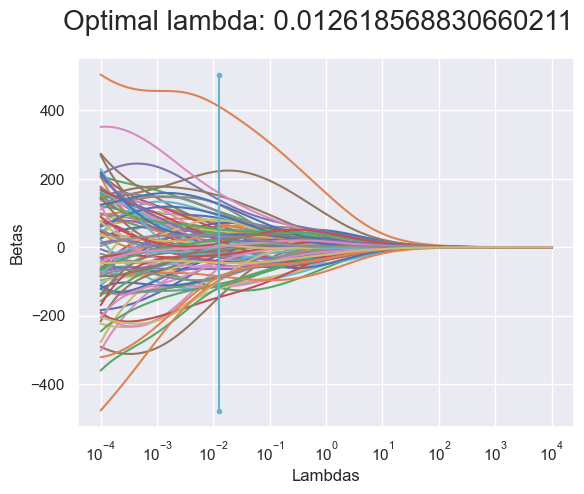

In [49]:
K = 10

#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-4, 4, k)
RMSE = np.zeros((10, 100))

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X_imputed_mean[I != i]
    yTrain = y[I != i]
    XTest = X_imputed_mean[I == i]
    yTest = y[I == i]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns
    
    
    #Fit ridgeregression
    for j in range(100):
        #beta = Ridge(alpha=lambdas[j]).fit(XTrain, yTrain).coef_
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        RMSE[(i - 1), j] = np.sqrt(np.mean((yTest - np.matmul(XTest, beta)) ** 2))

        
meanRMSE = np.mean(RMSE, axis = 0)
jOpt = np.argsort(meanRMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

In [50]:
print(f"Mean RMSE: {jOpt:.2f}")

Mean RMSE: 26.00


In [51]:
model = Ridge(alpha=lambda_OP)

# cross validation
K = 10
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1
I = I[np.random.permutation(n)]

RMSE = np.zeros((K, 1))

def cross_validdation(model, X, y):
    for i in range(1, K+1):
        XTrain = X[I != i]
        yTrain = y[I != i]
        XTest = X[I == i]
        yTest = y[I == i]
        
        yTrain, mu = centerData(yTrain)
        yTest = yTest-mu
        
        XTrain, mu = centerData(XTrain)
        XTest = XTest-mu
        
        XTrain,d = normalize(XTrain)
        XTest = XTest / d
        
        model.fit(XTrain, yTrain)
        RMSE[(i - 1)] = np.sqrt(mean_squared_error(yTest, model.predict(XTest)))
    return np.mean(RMSE)

ridge_rmse = cross_validdation(model, X_imputed_mean, y)

print(f"Mean RMSE: {ridge_rmse:.2f}")


Mean RMSE: 31.35


In [52]:
# linear regression model
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()

linear_rmse = cross_validdation(model_linear, X_imputed_mean, y)

print(f"Linear regression RMSE: {linear_rmse:.2f}")

Linear regression RMSE: 50.61


In [53]:
# OLS solution
import numpy.linalg as lng

def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    
    return betas, res, rnk, s

ols_rmse = cross_validdation(model_linear, X_imputed_mean, y)

print(f"OLS RMSE: {ols_rmse:.2f}")

OLS RMSE: 50.61


# Categorical Ridge Regression

In [54]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet

In [66]:
df = pd.read_csv('./case1Data.csv')

# Basic information
print("Dataset dimensions:", df.shape)
print("Column names:", df.columns.tolist())
print("\nData types and missing values:")
print(df.info())

print("\nFirst 5 rows of data:")
print(df.head())

print("\nStatistical description:")
print(df.describe(include='all'))

# Check missing values
print("\nNumber of missing values per column:")
print(df.isnull().sum())


Dataset dimensions: (100, 101)
Column names: ['y', 'x_01', 'x_02', 'x_03', 'x_04', 'x_05', 'x_06', 'x_07', 'x_08', 'x_09', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'x_68', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_79', 'x_80', 'x_81', 'x_82', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_90', 'x_91', 'x_92', 'x_93', 'x_94', 'x_95', 'C_01', 'C_02', 'C_03', 'C_04', 'C_05']

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 101 entries, y to C_05
dtypes: float6

Missing data handling

In [67]:
# Fill missing values in x_ numeric features with the mean
x_cols = [col for col in df.columns if col.startswith('x_')]
imputer_mean = SimpleImputer(strategy='mean')
df[x_cols] = imputer_mean.fit_transform(df[x_cols])

In [68]:
# Process C_ features:
# - Fill missing values with median, mode or 'Missing'
c_cols = [col for col in df.columns if col.startswith('C_')]
for col in c_cols:
    df[col] = df[col].fillna(df[col].median())
    # df[col] = df[col].fillna(df[col].mode())
    # df[col] = df[col].astype('str').fillna('Missing')
  

# Apply one-hot encoding to C_ variables
df_encoded = pd.get_dummies(df, columns=c_cols, drop_first=False)

In [69]:
# Remove features that have only a single unique value
unique_counts = df_encoded.nunique()
single_value_cols = unique_counts[unique_counts == 1].index
df_model = df_encoded.drop(columns=single_value_cols)

print("Shape of constructed df_model: ", df_model.shape)

Shape of constructed df_model:  (100, 116)


In [70]:
# Define feature groups: x_ numeric features and one-hot encoded categorical features
x_features = [col for col in df_model.columns if col.startswith('x_')]

cat_features = [col for col in df_model.columns if col not in x_features + ['y']]

print("Number of x_ features:", len(x_features))
print("Number of one-hot encoded categorical features:", len(cat_features))

Number of x_ features: 95
Number of one-hot encoded categorical features: 20


In [71]:
# Define preprocessor:
# - Apply standardization (Z-score) to x_ features
# - Pass categorical features through unchanged
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), x_features),
    ('cat', 'passthrough', cat_features)
])

# Define cross-validation strategy (5-fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
k = 100; # try k values of lambda
alphas = np.logspace(-4, 4, k)


In [72]:
# Build Ridge model pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', RidgeCV(alphas=alphas, cv=5))
])
ridge_cv_scores = cross_val_score(ridge_pipeline,
                                  df_model.drop(columns=['y']),
                                  df_model['y'],
                                  cv=cv,
                                  scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_cv_scores)
print("\nRidge model RMSE per fold:", ridge_rmse)
print("Ridge model average RMSE:", ridge_rmse.mean())

# Build Lasso model pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(alphas=alphas, cv=5, random_state=42))
])
lasso_cv_scores = cross_val_score(lasso_pipeline,
                                  df_model.drop(columns=['y']),
                                  df_model['y'],
                                  cv=cv,
                                  scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_cv_scores)
print("\nLasso model RMSE per fold:", lasso_rmse)
print("Lasso model average RMSE:", lasso_rmse.mean())

# Build ElasticNet model pipeline
enet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('enet', ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42))
])
enet_cv_scores = cross_val_score(enet_pipeline,
                                 df_model.drop(columns=['y']),
                                 df_model['y'],
                                 cv=cv,
                                 scoring='neg_mean_squared_error')
enet_rmse = np.sqrt(-enet_cv_scores)
print("\nElasticNet model RMSE per fold:", enet_rmse)
print("ElasticNet model average RMSE:", enet_rmse.mean())


Ridge model RMSE per fold: [39.97370206 31.21765856 16.44540337 36.80408749 21.93469865 33.68020515
 39.58786455 26.27669935 23.69474405 32.23334664]
Ridge model average RMSE: 30.18484098726759


d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.563e+01, tolerance: 3.507e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.474e+01, tolerance: 3.624e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5


Lasso model RMSE per fold: [36.81381924 38.93480331 27.32435464 31.2445952  21.68541914 28.99846221
 33.36040536 27.60609392 36.05437551 39.31703135]
Lasso model average RMSE: 32.133935986470625


d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+02, tolerance: 3.958e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.709e+01, tolerance: 3.958e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1


ElasticNet model RMSE per fold: [40.51528112 33.78719833 18.39888648 31.69272097 22.16566691 31.24236783
 36.56722888 24.39170858 26.00588502 34.74217954]
ElasticNet model average RMSE: 29.950912366838992


d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+02, tolerance: 4.629e+01
  model = cd_fast.enet_coordinate_descent(


# Plot the alpha vs rmse for Regular Ridge, Lasso, and Elastic Net Regression

In [73]:
# Ridge
ridge_rmse_path = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_regu_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', ridge)
    ])
    scores = cross_val_score(ridge_regu_pipeline,
                             df_model.drop(columns=['y']),
                             df_model['y'],
                             cv=5,
                             scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    ridge_rmse_path.append(rmse)

ridge_rmse_path = np.array(ridge_rmse_path)

# Lasso
lasso_regu_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(alphas=alphas, cv=5, random_state=42))
])
lasso_regu_pipeline.fit(df_model.drop(columns=['y']), df_model['y'])
lasso_rmse_path = np.sqrt(lasso_regu_pipeline.named_steps['lasso'].mse_path_.mean(axis=1))

# ElasticNet (3 l1_ratios)
enet_rmse_paths = {}
for l1_ratio in [0.1, 0.5, 0.9]:
    enet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5, random_state=42)
    enet_regu_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('enet', enet)
    ])
    enet_regu_pipeline.fit(df_model.drop(columns=['y']), df_model['y'])
    rmse_path = np.sqrt(enet_regu_pipeline.named_steps['enet'].mse_path_.mean(axis=1))
    enet_rmse_paths[l1_ratio] = rmse_path

d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e+01, tolerance: 3.782e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.554e+01, tolerance: 3.782e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

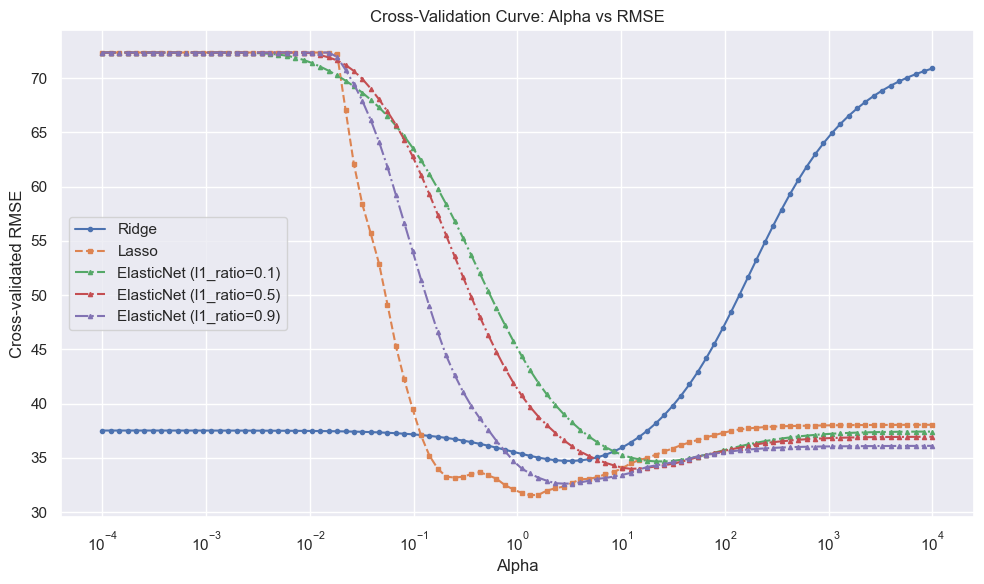

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_rmse_path, label='Ridge', linestyle='-', marker='o', markersize=3)
plt.plot(alphas, lasso_rmse_path, label='Lasso', linestyle='--', marker='s', markersize=3)
for l1_ratio, rmse_path in enet_rmse_paths.items():
    plt.plot(alphas, rmse_path, label=f'ElasticNet (l1_ratio={l1_ratio})', linestyle='-.', marker='^', markersize=3)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-validated RMSE')
plt.title('Cross-Validation Curve: Alpha vs RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Valiation

In [75]:
X = df_model.drop(columns=['y'])
y = df_model['y']

# Ridge Validation
ridge_pipeline.fit(X, y)
best_ridge_alpha = ridge_pipeline.named_steps['ridge'].alpha_
print(f"Best Ridge alpha: {best_ridge_alpha}")

final_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=best_ridge_alpha))
])
ridge_cv_scores = cross_val_score(final_ridge, X, y, cv=cv, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_cv_scores)
print("\n[Ridge] RMSE per fold:", ridge_rmse)
print("[Ridge] Average RMSE:", ridge_rmse.mean())

# Lasso Validation
lasso_pipeline.fit(X, y)
best_lasso_alpha = lasso_pipeline.named_steps['lasso'].alpha_
print(f"Best Lasso alpha: {best_lasso_alpha}")

final_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=best_lasso_alpha))
])
lasso_cv_scores = cross_val_score(final_lasso, X, y, cv=cv, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_cv_scores)
print("\n[Lasso] RMSE per fold:", lasso_rmse)
print("[Lasso] Average RMSE:", lasso_rmse.mean())

# ElasticNet Validation
enet_pipeline.fit(X, y)
best_enet_alpha = enet_pipeline.named_steps['enet'].alpha_
best_enet_l1_ratio = enet_pipeline.named_steps['enet'].l1_ratio_
print(f"Best ElasticNet alpha: {best_enet_alpha}")
print(f"Best ElasticNet l1_ratio: {best_enet_l1_ratio}")

final_enet = Pipeline([
    ('preprocessor', preprocessor),
    ('enet', ElasticNet(alpha=best_enet_alpha, l1_ratio=best_enet_l1_ratio))
])
enet_cv_scores = cross_val_score(final_enet, X, y, cv=cv, scoring='neg_mean_squared_error')
enet_rmse = np.sqrt(-enet_cv_scores)
print("\n[ElasticNet] RMSE per fold:", enet_rmse)
print("[ElasticNet] Average RMSE:", enet_rmse.mean())

Best Ridge alpha: 4.037017258596558

[Ridge] RMSE per fold: [39.61258014 29.88888933 15.3628028  36.17995227 21.7342704  33.2016703
 39.22167513 26.39960429 21.35644094 32.89422083]
[Ridge] Average RMSE: 29.585210643893056


d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e+01, tolerance: 3.782e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.554e+01, tolerance: 3.782e+01
  model = cd_fast.enet_coordinate_descent(


Best Lasso alpha: 0.7564633275546291

[Lasso] RMSE per fold: [36.93186246 40.04584638 28.13383574 25.09662119 19.30948776 28.69731226
 32.63708449 27.60609392 30.53019929 37.57624003]
[Lasso] Average RMSE: 30.656458351754413


d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+02, tolerance: 4.391e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e+02, tolerance: 4.391e+01
  model = cd_fast.enet_coordinate_descent(
d:\VSC_Python_WorkSpace\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

Best ElasticNet alpha: 0.3593813663804629
Best ElasticNet l1_ratio: 0.9

[ElasticNet] RMSE per fold: [40.51528112 35.337553   16.95935256 31.06008311 21.96770953 31.70889044
 33.58877252 24.16359443 24.37373476 36.39118414]
[ElasticNet] Average RMSE: 29.606615559818305
